# This notebook contains visualization and evaluation of the benchmarking LSTM-based early prediction model

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray


from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from scipy.stats import norm
from properscoring import crps_gaussian

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [2]:
training_cells = pd.read_csv("../Data_preprocessing/training.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_in_cells = pd.read_csv("../Data_preprocessing/test_in.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_out_cells = pd.read_csv("../Data_preprocessing/test_out.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()


num_training_cells = len(training_cells)
num_test_in_cells = len(test_in_cells)
num_test_out_cells = len(test_out_cells)

In [3]:
# Load completed trajectory data for visualization
with open('Data/trajectory_train_interp.pkl', 'rb') as f:    
    trajectory_train = pickle.load(f)
with open('Data/trajectory_test_in_interp.pkl', 'rb') as f:
    trajectory_test_in = pickle.load(f)
with open('Data/trajectory_test_out_interp.pkl', 'rb') as f:
    trajectory_test_out = pickle.load(f)

# Load true trajectory for evaluation
with open("Results/Q_train_true.pkl", "rb") as f:
    Q_train_true = pickle.load(f)
with open("Results/Q_test_in_true.pkl", "rb") as f:
    Q_test_in_true = pickle.load(f)
with open("Results/Q_test_out_true.pkl", "rb") as f:
    Q_test_out_true = pickle.load(f)

# Load predicted trajectory - mean
with open("Results/Q_train_pred_5_ensemble.pkl", "rb") as f:
    Q_train_pred = pickle.load(f)
with open("Results/Q_test_in_pred_5_ensemble.pkl", "rb") as f:
    Q_test_in_pred = pickle.load(f)
with open("Results/Q_test_out_pred_5_ensemble.pkl", "rb") as f:
    Q_test_out_pred = pickle.load(f)

# Load predicted trajectory - std
with open('Results/std_train_pred_5_ensemble.pkl', 'rb') as f:
    std_train_pred = pickle.load(f)
with open('Results/std_test_in_pred_5_ensemble.pkl', 'rb') as f:
    std_test_in_pred = pickle.load(f)
with open('Results/std_test_out_pred_5_ensemble.pkl', 'rb') as f:
    std_test_out_pred = pickle.load(f)

In [81]:
def calculate_confidence_intervals(Q_hat_combined, Q_true, std_combined):
    K_c = 11
    c_all = np.linspace(0, 1, K_c)
    c_all[0] = 0.01
    c_all[-1] = 0.99

    num_obs = Q_true.shape[0]
    z_all = norm.ppf((1 + c_all) / 2)  # Calculate z values for two-sided intervals
    ind = np.zeros((K_c, num_obs))  # To store boolean results
    c_hat = np.zeros(K_c)  # Store observed confidence levels

    for j in range(K_c):
        z = z_all[j]
        ind[j, :] = (Q_true >= Q_hat_combined - z * std_combined) & (Q_true <= Q_hat_combined + z * std_combined)
        c_hat[j] = np.sum(ind[j, :]) / (num_obs)

    ECE = np.mean(np.abs(c_hat - c_all))
    return c_hat, ECE

def negative_log_likelihood(predicted_means, predicted_stds, targets):
    """
    Calculate the negative log-likelihood (NLL) for a set of probabilistic predictions
    assuming a normal distribution for each prediction.
    
    Parameters:
    - predicted_means: Array of predicted means (mu) from the model
    - predicted_stds: Array of predicted standard deviations (sigma) from the model
    - targets: Array of true target values (y)
    
    Returns:
    - nll: Negative log-likelihood value for the dataset
    """
    # Ensure no zero or negative standard deviations (to avoid log(0) or divide by zero)
    if np.any(predicted_stds <= 0):
        raise ValueError("Standard deviations must be positive.")

    # Calculate the negative log-likelihood for each data point
    nll = (0.5 * np.log(2 * np.pi * predicted_stds**2) + 
           ((targets - predicted_means)**2) / (2 * predicted_stds**2))
    
    # Return the mean of NLL for all samples
    return np.mean(nll)

## Analyze the training data

In [111]:
# Create a list to store the evaluation metrics for each fold
MAE_train = []
ECE_train = []
NLL_train = []
CRPS_train = []
cali_train = []

# Loop over each fold
for fold in range(10):
    # Load the data for the current fold
    Q_train_pred_fold = Q_train_pred[fold]
    std_train_pred_fold = std_train_pred[fold]

    # Initialize lists to store the evaluation metrics for each cell
    MAE_fold = []
    CRPS_fold = []

    # Initialize arrays to store the predicted and true values for all cells
    for iii,cell in enumerate(training_cells):
        if iii == 0:
            Q_train_true_fold = Q_train_true[cell][10:].copy()*100
            Q_all_fold = Q_train_pred_fold[cell].copy()*100
            std_all_fold = std_train_pred_fold[cell].copy()*100
        Q_train_true_cell = Q_train_true[cell][10:]*100
        Q_train_pred_cell = Q_train_pred_fold[cell]*100
        std_train_pred_cell = std_train_pred_fold[cell]*100
        # Calculate evaluation metrics for the current cell
        MAE_fold.append(mean_absolute_error(Q_train_true_cell, Q_train_pred_cell))
        # Calculate CRPS for the current cell
        CRPS_cell = []
        for jjj in range(len(Q_train_true_cell)):
            CRPS_cell.append(crps_gaussian(Q_train_true_cell[jjj], mu = Q_train_pred_cell[jjj], sig=std_train_pred_cell[jjj]))
        CRPS_fold.append(np.mean(CRPS_cell))
        # Append the predicted and true values for the current cell to the arrays
        if iii != 0:
            Q_all_fold = np.concatenate((Q_all_fold, Q_train_pred_cell), axis=0)
            std_all_fold = np.concatenate((std_all_fold, std_train_pred_cell), axis=0)
            Q_train_true_fold = np.concatenate((Q_train_true_fold, Q_train_true_cell), axis=0)


    # Calculate the overall evaluation metrics for the current fold
    MAE_train.append(np.mean(MAE_fold))
    CRPS_train.append(np.mean(CRPS_fold))
    c_hat_train, ECE_train_fold = calculate_confidence_intervals(Q_all_fold, Q_train_true_fold, std_all_fold)
    ECE_train.append(ECE_train_fold)
    NLL_train.append(negative_log_likelihood(Q_all_fold, std_all_fold, Q_train_true_fold))
    cali_train.append(c_hat_train)

print("Training MAE: {:.2f}".format(np.mean(MAE_train)))
print("Training ECE: {:.3f}".format(np.mean(ECE_train)))
print("Training NLL: {:.2f}".format(np.mean(NLL_train)))
print("Training CRPS: {:.2f}".format(np.mean(CRPS_train)))
      



Training MAE: 1.44
Training ECE: 0.120
Training NLL: 2.15
Training CRPS: 1.06


In [110]:
# Create a list to store the evaluation metrics for each fold
MAE_test_in = []
ECE_test_in = []
NLL_test_in = []
CRPS_test_in = []
cali_test_in = []

# Loop over each fold
for fold in range(10):
    # Load the data for the current fold
    Q_test_in_pred_fold = Q_test_in_pred[fold]
    std_test_in_pred_fold = std_test_in_pred[fold]

    # Initialize lists to store the evaluation metrics for each cell
    MAE_fold = []
    CRPS_fold = []

    # Initialize arrays to store the predicted and true values for all cells
    for iii,cell in enumerate(test_in_cells):
        if iii == 0:
            Q_test_in_true_fold = Q_test_in_true[cell][10:].copy()*100
            Q_all_fold = Q_test_in_pred_fold[cell].copy()*100
            std_all_fold = std_test_in_pred_fold[cell].copy()*100
        Q_test_in_true_cell = Q_test_in_true[cell][10:]*100
        Q_test_in_pred_cell = Q_test_in_pred_fold[cell]*100
        std_test_in_pred_cell = std_test_in_pred_fold[cell]*100
        # Calculate evaluation metrics for the current cell
        MAE_fold.append(mean_absolute_error(Q_test_in_true_cell, Q_test_in_pred_cell))
        # Calculate CRPS for the current cell
        CRPS_cell = []
        for jjj in range(len(Q_test_in_true_cell)):
            CRPS_cell.append(crps_gaussian(Q_test_in_true_cell[jjj], mu = Q_test_in_pred_cell[jjj], sig=std_test_in_pred_cell[jjj]))
        CRPS_fold.append(np.mean(CRPS_cell))
        # Append the predicted and true values for the current cell to the arrays
        if iii != 0:
            Q_all_fold = np.concatenate((Q_all_fold, Q_test_in_pred_cell), axis=0)
            std_all_fold = np.concatenate((std_all_fold, std_test_in_pred_cell), axis=0)
            Q_test_in_true_fold = np.concatenate((Q_test_in_true_fold, Q_test_in_true_cell), axis=0)


    # Calculate the overall evaluation metrics for the current fold
    MAE_test_in.append(np.mean(MAE_fold))
    CRPS_test_in.append(np.mean(CRPS_fold))
    c_hat_test_in, ECE_test_in_fold = calculate_confidence_intervals(Q_all_fold, Q_test_in_true_fold, std_all_fold)
    ECE_test_in.append(ECE_test_in_fold)
    NLL_test_in.append(negative_log_likelihood(Q_all_fold, std_all_fold, Q_test_in_true_fold))
    cali_test_in.append(c_hat_test_in)

print("Test-in MAE: {:.2f}".format(np.mean(MAE_test_in)))
print("Test-in ECE: {:.3f}".format(np.mean(ECE_test_in)))
print("Test-in NLL: {:.2f}".format(np.mean(NLL_test_in)))
print("Test-in CRPS: {:.2f}".format(np.mean(CRPS_test_in)))


Test-in MAE: 2.30
Test-in ECE: 0.141
Test-in NLL: 2.62
Test-in CRPS: 1.67


In [109]:
# Create a list to store the evaluation metrics for each fold
MAE_test_out = []
ECE_test_out = []
NLL_test_out = []
CRPS_test_out = []
cali_test_out = []

# Loop over each fold
for fold in range(10):
    # Load the data for the current fold
    Q_test_out_pred_fold = Q_test_out_pred[fold]
    std_test_out_pred_fold = std_test_out_pred[fold]

    # Initialize lists to store the evaluation metrics for each cell
    MAE_fold = []
    CRPS_fold = []

    # Initialize arrays to store the predicted and true values for all cells
    for iii,cell in enumerate(test_out_cells):
        if iii == 0:
            Q_test_out_true_fold = Q_test_out_true[cell][10:].copy()*100
            Q_all_fold = Q_test_out_pred_fold[cell].copy()*100
            std_all_fold = std_test_out_pred_fold[cell].copy()*100
        Q_test_out_true_cell = Q_test_out_true[cell][10:]*100
        Q_test_out_pred_cell = Q_test_out_pred_fold[cell]*100
        std_test_out_pred_cell = std_test_out_pred_fold[cell]*100
        # Calculate evaluation metrics for the current cell
        MAE_fold.append(mean_absolute_error(Q_test_out_true_cell, Q_test_out_pred_cell))
        # Calculate CRPS for the current cell
        CRPS_cell = []
        for jjj in range(len(Q_test_out_true_cell)):
            CRPS_cell.append(crps_gaussian(Q_test_out_true_cell[jjj], mu = Q_test_out_pred_cell[jjj], sig=std_test_out_pred_cell[jjj]))
        CRPS_fold.append(np.mean(CRPS_cell))
        # Append the predicted and true values for the current cell to the arrays
        if iii != 0:
            Q_all_fold = np.concatenate((Q_all_fold, Q_test_out_pred_cell), axis=0)
            std_all_fold = np.concatenate((std_all_fold, std_test_out_pred_cell), axis=0)
            Q_test_out_true_fold = np.concatenate((Q_test_out_true_fold, Q_test_out_true_cell), axis=0)


    # Calculate the overall evaluation metrics for the current fold
    MAE_test_out.append(np.mean(MAE_fold))
    CRPS_test_out.append(np.mean(CRPS_fold))
    c_hat_test_out, ECE_test_out_fold = calculate_confidence_intervals(Q_all_fold, Q_test_out_true_fold, std_all_fold)
    ECE_test_out.append(ECE_test_out_fold)
    NLL_test_out.append(negative_log_likelihood(Q_all_fold, std_all_fold, Q_test_out_true_fold))
    cali_test_out.append(c_hat_test_out)

print("Test-out MAE: {:.2f}".format(np.mean(MAE_test_out)))
print("Test-out ECE: {:.3f}".format(np.mean(ECE_test_out)))
print("Test-out NLL: {:.2f}".format(np.mean(NLL_test_out)))
print("Test-out CRPS: {:.2f}".format(np.mean(CRPS_test_out)))


Test-out MAE: 5.14
Test-out ECE: 0.107
Test-out NLL: 7.43
Test-out CRPS: 3.52


# Visualization

In [85]:
# Import data from NNE models
MAE_df_NNE = pd.read_csv("MAE_df_e2e.csv")
ECE_df_NNE = pd.read_csv("ECE_df_e2e.csv")
NLL_df_NNE = pd.read_csv("NLL_df_e2e.csv")
CRPS_df_NNE = pd.read_csv("CRPS_df_e2e.csv")

# Import calibration
with open("cali_dict_e2e.pkl", "rb") as f:
    cali_NNE = pickle.load(f)
cali_NNE_train = cali_NNE["cali_train"]
cali_NNE_test_in = cali_NNE["cali_test_in"]
cali_NNE_test_out = cali_NNE["cali_test_out"]

MAE_df_NNE['Model Type'] = 'E2E-NNE'
ECE_df_NNE['Model Type'] = 'E2E-NNE'
NLL_df_NNE['Model Type'] = 'E2E-NNE'
CRPS_df_NNE['Model Type'] = 'E2E-NNE'



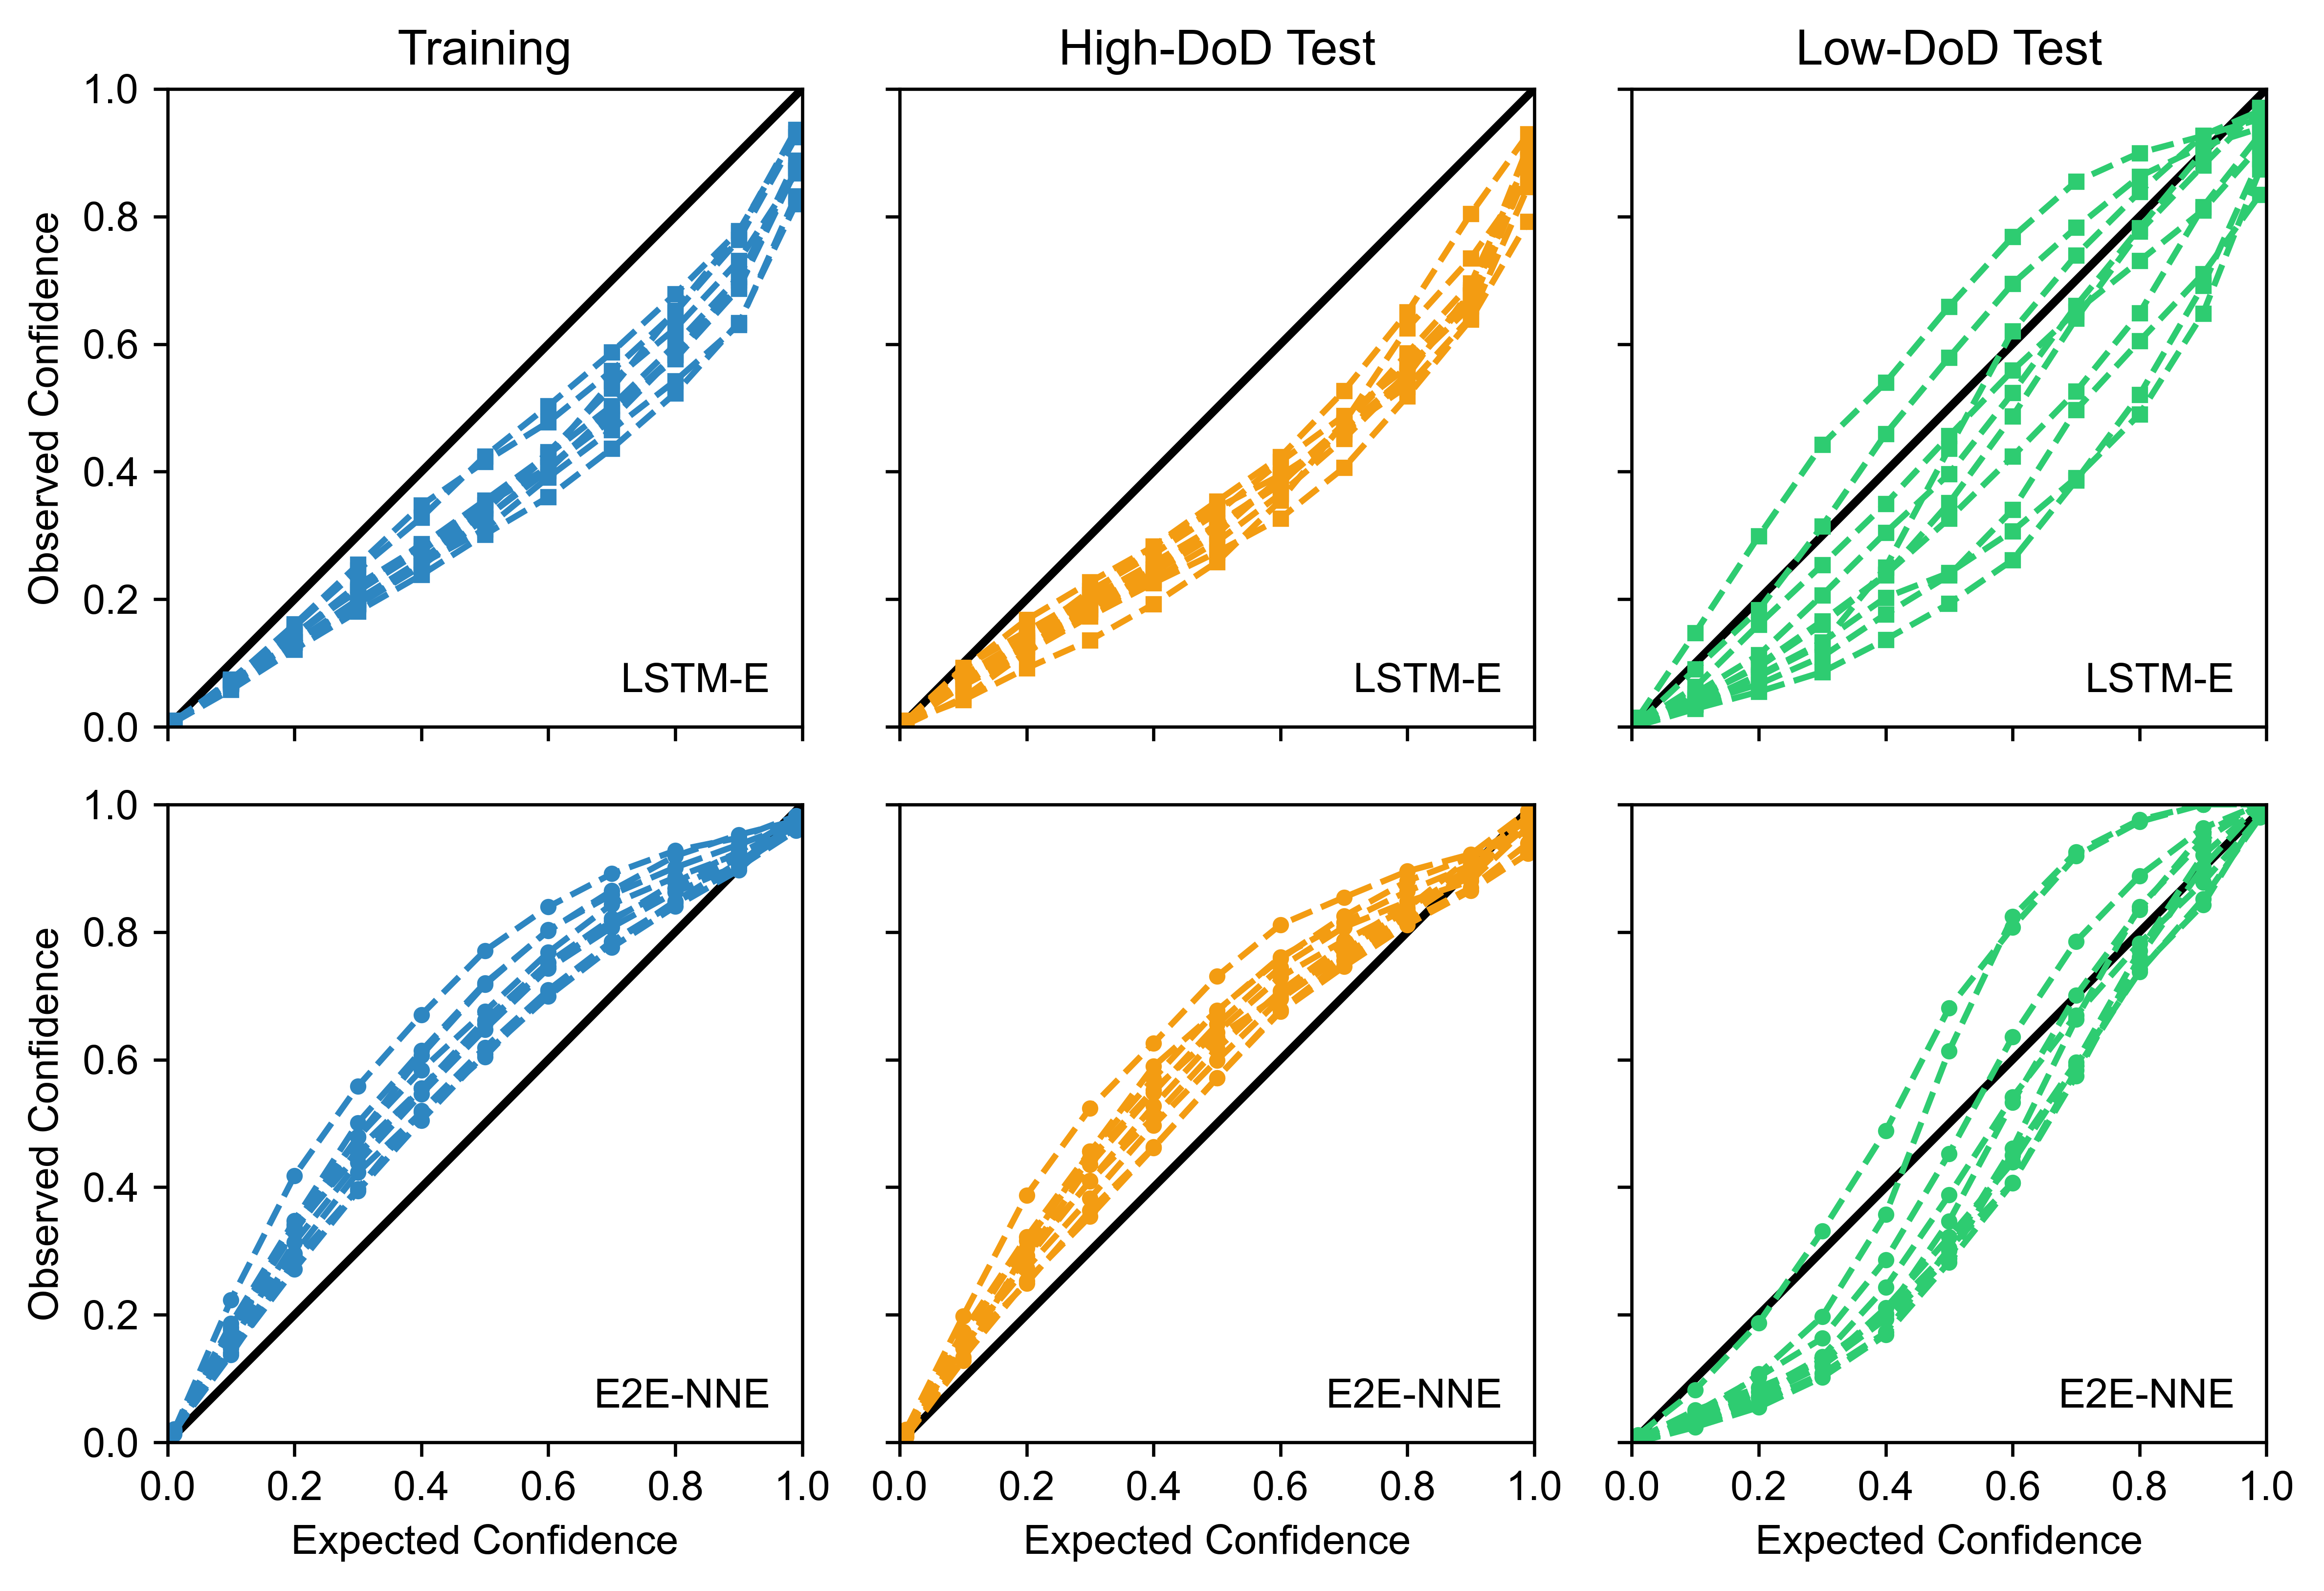

In [ ]:
K_c = 11
c_all = np.linspace(0, 1, K_c)
c_all[0] = 0.01
c_all[-1] = 0.99
colors = ["#2E86C1","#F39C12","#2ECC71",[0.5,0.5,0.5]]

fig, axs = plt.subplots(2, 3, figsize=(8, 5.5), dpi=600,sharey=True,sharex=True)

model_name = ['LSTM-E','E2E-NNE']
for i, ax in enumerate(axs.flat):
    ax.text(0.95, 0.1, f'{model_name[i//3]}', transform=ax.transAxes, fontsize=10, verticalalignment='top',horizontalalignment='right',  backgroundcolor=(1,1,1,0.9))
    ax.plot([0, 1], [0, 1], 'k', linewidth=2)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

for fold in range(10):
    axs[0,0].plot(c_all, cali_train[fold], 's--', c=colors[0], markersize=3, linewidth=1.5)
    axs[0,1].plot(c_all, cali_test_in[fold], 's--', c=colors[1], markersize=3, linewidth=1.5)
    axs[0,2].plot(c_all, cali_test_out[fold], 's--', c=colors[2], markersize=3, linewidth=1.5)

    axs[1,0].plot(c_all, cali_NNE_train[fold], '.--', c=colors[0], markersize=6, linewidth=1.5)
    axs[1,1].plot(c_all, cali_NNE_test_in[fold], '.--', c=colors[1], markersize=6, linewidth=1.5)
    axs[1,2].plot(c_all, cali_NNE_test_out[fold], '.--', c=colors[2], markersize=6, linewidth=1.5)

axs[0,0].set_title('Training')
axs[0,1].set_title('High-DoD Test')
axs[0,2].set_title('Low-DoD Test')
axs[0,0].set_ylabel('Observed Confidence')
axs[0,0].set_yticks([0,0.2,0.4,0.6,0.8,1])
axs[1,0].set_ylabel('Observed Confidence')
axs[1,0].set_yticks([0,0.2,0.4,0.6,0.8,1])



axs[1,0].set_xlabel('Expected Confidence')
axs[1,0].set_xticks([0,0.2,0.4,0.6,0.8,1])
axs[1,1].set_xlabel('Expected Confidence')
axs[1,1].set_xticks([0,0.2,0.4,0.6,0.8,1])
axs[1,2].set_xlabel('Expected Confidence')
axs[1,2].set_xticks([0,0.2,0.4,0.6,0.8,1])

plt.tight_layout(pad=1)
plt.show()

In [87]:
MAE_plot = []
NLL_plot = []
ECE_plot = []
CRPS_plot = []
model_type = []
data_subset = []

for i in range(10):
    MAE_plot.append(MAE_train[i])
    NLL_plot.append(NLL_train[i])
    ECE_plot.append(ECE_train[i])
    CRPS_plot.append(CRPS_train[i])
    model_type.append('LSTM-E')
    data_subset.append('Training')

    MAE_plot.append(MAE_test_in[i])
    NLL_plot.append(NLL_test_in[i])
    ECE_plot.append(ECE_test_in[i])
    CRPS_plot.append(CRPS_test_in[i])
    model_type.append('LSTM-E')
    data_subset.append('High-DoD\nTest')

    MAE_plot.append(MAE_test_out[i])
    NLL_plot.append(NLL_test_out[i])
    ECE_plot.append(ECE_test_out[i])
    CRPS_plot.append(CRPS_test_out[i])
    model_type.append('LSTM-E')
    data_subset.append('Low-DoD\nTest')


MAE_df = pd.DataFrame({'Error': MAE_plot, 'Model Type': model_type, 'Data Subset': data_subset})
NLL_df = pd.DataFrame({'Error': NLL_plot, 'Model Type': model_type, 'Data Subset': data_subset})
ECE_df = pd.DataFrame({'Error': ECE_plot, 'Model Type': model_type, 'Data Subset': data_subset})
CRPS_df = pd.DataFrame({'Error': CRPS_plot, 'Model Type': model_type, 'Data Subset': data_subset})

MAE_df = pd.concat([MAE_df, MAE_df_NNE], axis=0)
NLL_df = pd.concat([NLL_df, NLL_df_NNE], axis=0)
ECE_df = pd.concat([ECE_df, ECE_df_NNE], axis=0)
CRPS_df = pd.concat([CRPS_df, CRPS_df_NNE], axis=0)

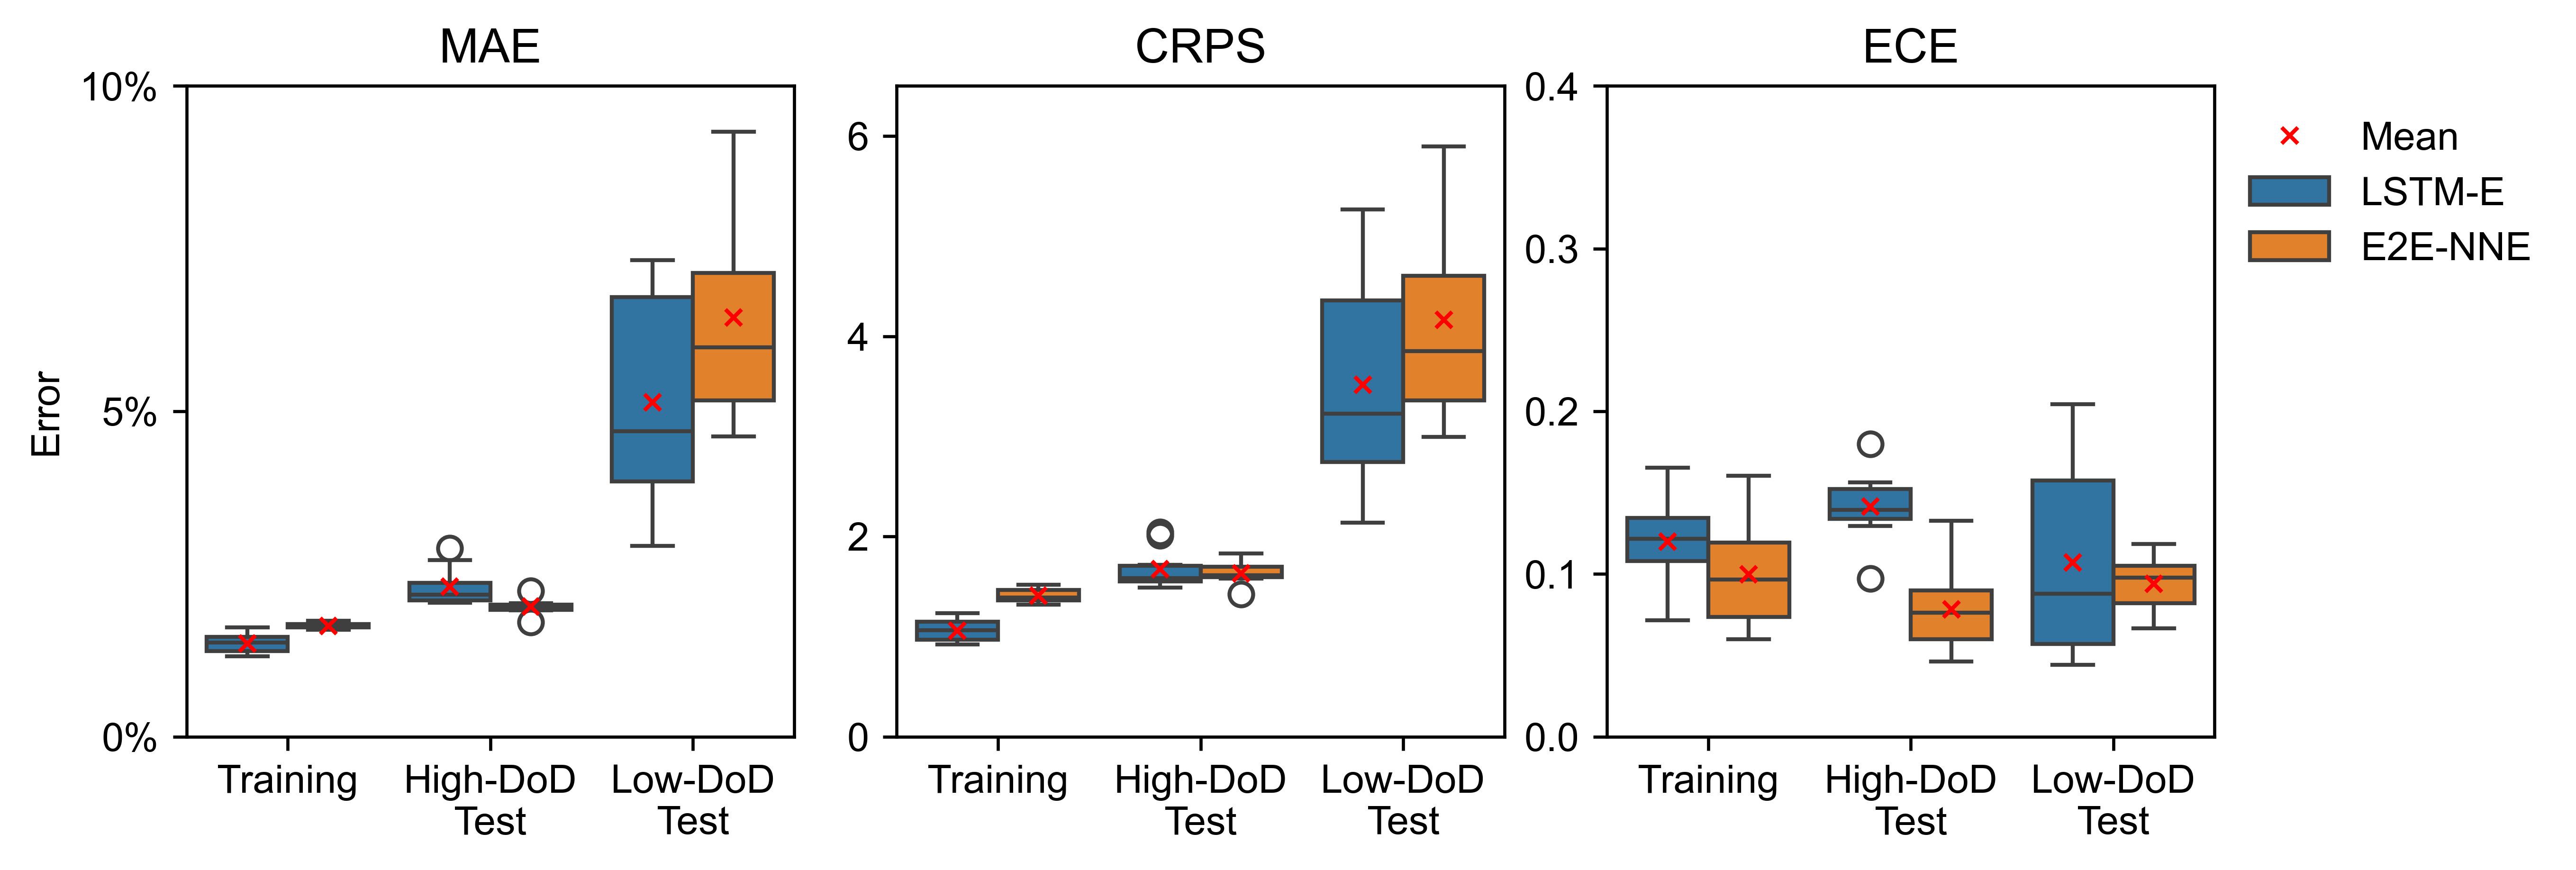

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3),dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

sns.boxplot(data=MAE_df,x='Data Subset',y='Error',hue='Model Type',ax=ax[0],showmeans=True,
             meanprops={'marker':'x',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'red',
                       'markersize':'4',
                       'label':'Mean'})
ax[0].set_title('MAE')
ax[0].set_ylim(0,10)
ax[0].set_yticks([0,5,10])
ax[0].set_yticklabels(['0%','5%','10%'])
ax[0].set_ylabel('Error')
ax[0].set_xlabel(None)
ax[0].legend().set_visible(False)


sns.boxplot(data=CRPS_df,x='Data Subset',y='Error',hue='Model Type',ax=ax[1],showmeans=True,
             meanprops={'marker':'x',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'red',
                       'markersize':'4'})
ax[1].set_title('CRPS')
ax[1].set_ylim(0,6.5)
ax[1].set_yticks([0,2,4,6])
# ax[1].set_yticklabels(['0%','2%','4%','6%','8%','10%'])
ax[1].legend().set_visible(False)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)


sns.boxplot(data=ECE_df,x='Data Subset',y='Error',hue='Model Type',ax=ax[2],showmeans=True,
             meanprops={'marker':'x',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'red',
                       'markersize':'4',
                       'label':'Mean'})
ax[2].set_title('ECE')
ax[2].set_ylim(0,0.4)
ax[2].set_yticks([0,0.1,0.2,0.3,0.4])
# ax[2].set_yticklabels(['0%','10%','20%','30%','40%'])
# ax[2].legend().set_visible(False)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].legend_.set_title(None)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[-3:], labels[-3:],loc=2,bbox_to_anchor=(1, 1),frameon=False)

plt.tight_layout(pad=0.5)
plt.show()

# Visualize the trajectory panel plot

In [ ]:
Q_raw = pd.read_csv('../NMC_data_V2.csv')


selected_train = [49,80,5,20]
selected_test_in = [5,10,20,30]
selected_test_out = [7,15,20,50]

colors = ['#a569bd','#5dade2','#e67e22','#f5b041']
linestyle = [':','--','-.']

def plot(fold):
    fig, ax = plt.subplots(4,3,figsize=(8,10),sharex=True,sharey=True,dpi=300)
    marker_size = 3

    for i in range(4):
        train_cell_ = training_cells[selected_train[i]]
        # Load the true measurements from the raw data
        N_true_train = Q_raw[Q_raw['cellID']==train_cell_]['Ah_throughput'].to_numpy()
        Q_true_train = Q_raw[Q_raw['cellID']==train_cell_]['qdis'].to_numpy()
        # Get the interpolated trajectory for the current cell
        N_interp_train = trajectory_train[train_cell_][0]
        # Get the predicted trajectory for the current cell
        Q_pred_train_fold = Q_train_pred[fold][train_cell_]*100
        # Get the standard deviation for the predicted trajectory
        std_train_fold = std_train_pred[fold][train_cell_]*100
        # Get the length of prediction
        len_pred = len(Q_pred_train_fold)

        # Plot early-life region
        g = int(train_cell_[1:-2])
        if g<20:
            ax[i,0].fill_betweenx([0,105], N_true_train[0],N_true_train[3], color='red', alpha=0.5, label='Early-life')
        else:
            ax[i,0].fill_betweenx([0,105], N_true_train[0],N_true_train[4], color='red', alpha=0.5, label='Early-life')
        
        # Plot the true true trajectory
        ax[i,0].plot(N_true_train,Q_true_train*100,'k-o',label='True',markersize=marker_size)

        # Plot the predicted trajectory
        ax[i,0].plot(N_interp_train[-len_pred:],Q_pred_train_fold,label='LSTM-E',c=colors[2],linestyle=linestyle[2])
        ax[i,0].fill_between(N_interp_train[-len_pred:],
                            (Q_pred_train_fold-2*std_train_fold),
                            (Q_pred_train_fold+2*std_train_fold),
                            alpha=0.2,color=colors[2],label='$\pm 2\sigma$')
        ax[i,0].set_title(f'Training -  {training_cells[selected_train[i]]}')
        # ax[i,0].legend()
        ax[i,0].set_ylim(80,102)
        ax[i,0].set_xlim(0,750)
        ax[i,0].grid()

        test_in_cell_ = test_in_cells[selected_test_in[i]]
        N_true_test_in = Q_raw[Q_raw['cellID']==test_in_cell_]['Ah_throughput'].to_numpy()
        Q_true_test_in = Q_raw[Q_raw['cellID']==test_in_cell_]['qdis'].to_numpy()
        # Get the interpolated trajectory for the current cell
        N_interp_test_in = trajectory_test_in[test_in_cell_][0]
        # Get the predicted trajectory for the current cell
        Q_pred_test_in_fold = Q_test_in_pred[fold][test_in_cell_]*100
        # Get the standard deviation for the predicted trajectory
        std_test_in_fold = std_test_in_pred[fold][test_in_cell_]*100
        # Get the length of prediction
        len_pred = len(Q_pred_test_in_fold)

        # Plot early-life region
        g = int(test_in_cell_[1:-2])
        if g<20:
            ax[i,1].fill_betweenx([0,105], N_true_test_in[0],N_true_test_in[3], color='red', alpha=0.5, label='Early-life') 
        else:
            ax[i,1].fill_betweenx([0,105], N_true_test_in[0],N_true_test_in[4], color='red', alpha=0.5, label='Early-life')

        # Plot the true true trajectory
        ax[i,1].plot(N_true_test_in,Q_true_test_in*100,'k-o',label='True',markersize=marker_size)
        # Plot the predicted trajectory
        ax[i,1].plot(N_interp_test_in[-len_pred:],Q_pred_test_in_fold,label='LSTM-E',c=colors[2],linestyle=linestyle[2])
        ax[i,1].fill_between(N_interp_test_in[-len_pred:],
                            (Q_pred_test_in_fold-2*std_test_in_fold),
                            (Q_pred_test_in_fold+2*std_test_in_fold),
                            alpha=0.2,color=colors[2],label='$\pm 2\sigma$')
        ax[i,1].set_title(f'High-DoD Test - {test_in_cells[selected_test_in[i]]}')
        # ax[i,1].legend()
        ax[i,1].set_ylim(80,102)
        ax[i,1].set_xlim(0,750)
        ax[i,1].grid()

        test_out_cell_ = test_out_cells[selected_test_out[i]]
        # Load the true measurements from the raw data
        N_true_test_out = Q_raw[Q_raw['cellID']==test_out_cell_]['Ah_throughput'].to_numpy()
        Q_true_test_out = Q_raw[Q_raw['cellID']==test_out_cell_]['qdis'].to_numpy()
        # Get the interpolated trajectory for the current cell
        N_interp_test_out = trajectory_test_out[test_out_cell_][0]
        # Get the predicted trajectory for the current cell
        Q_pred_test_out_fold = Q_test_out_pred[fold][test_out_cell_]*100
        # Get the standard deviation for the predicted trajectory
        std_test_out_fold = std_test_out_pred[fold][test_out_cell_]*100
        # Get the length of prediction
        len_pred = len(Q_pred_test_out_fold)

        # Plot early-life region
        g = int(test_out_cell_[1:-2])
        if g<20:
            ax[i,2].fill_betweenx([0,105], N_true_test_out[0],N_true_test_out[3], color='red', alpha=0.5, label='Early-life')
        else:
            ax[i,2].fill_betweenx([0,105], N_true_test_out[0],N_true_test_out[4], color='red', alpha=0.5, label='Early-life')
        
        # Plot the true true trajectory
        ax[i,2].plot(N_true_test_out,Q_true_test_out*100,'k-o',label='True',markersize=marker_size)
        # Plot the predicted trajectory
        ax[i,2].plot(N_interp_test_out[-len_pred:],Q_pred_test_out_fold,label='LSTM-E',c=colors[2],linestyle=linestyle[2])

        ax[i,2].fill_between(N_interp_test_out[-len_pred:],
                            (Q_pred_test_out_fold - std_test_out_fold*2),
                            (Q_pred_test_out_fold + std_test_out_fold*2),
                            alpha=0.2,color=colors[2],label='$\pm 2\sigma$')
        
        
        ax[i,2].set_title(f'Low-DoD Test - {test_out_cells[selected_test_out[i]]}')
        # ax[i,2].legend()
        ax[i,2].set_ylim(80,102)
        ax[i,2].set_xlim(0,750)

        ax[i,2].grid()

    for i in range(4):
        ax[i,0].set_ylabel('Normalized capacity (%)')
        # ax[i,1].set_ylabel('Normalized capacity (%)')
        # ax[i,2].set_ylabel('Normalized capacity (%)')

    for i in range(3):
        ax[3,i].set_xlabel('Ah-throughput')

    handles, labels = ax[0, 2].get_legend_handles_labels()  # Adjust the legend position
    # ax[1, 2].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0), frameon=False)
    ax[0, 2].legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))  # ,frameon=False)
    # fig.suptitle('Benchmarking of LSTM-E models')
    plt.tight_layout(pad=1)

    plt.show()


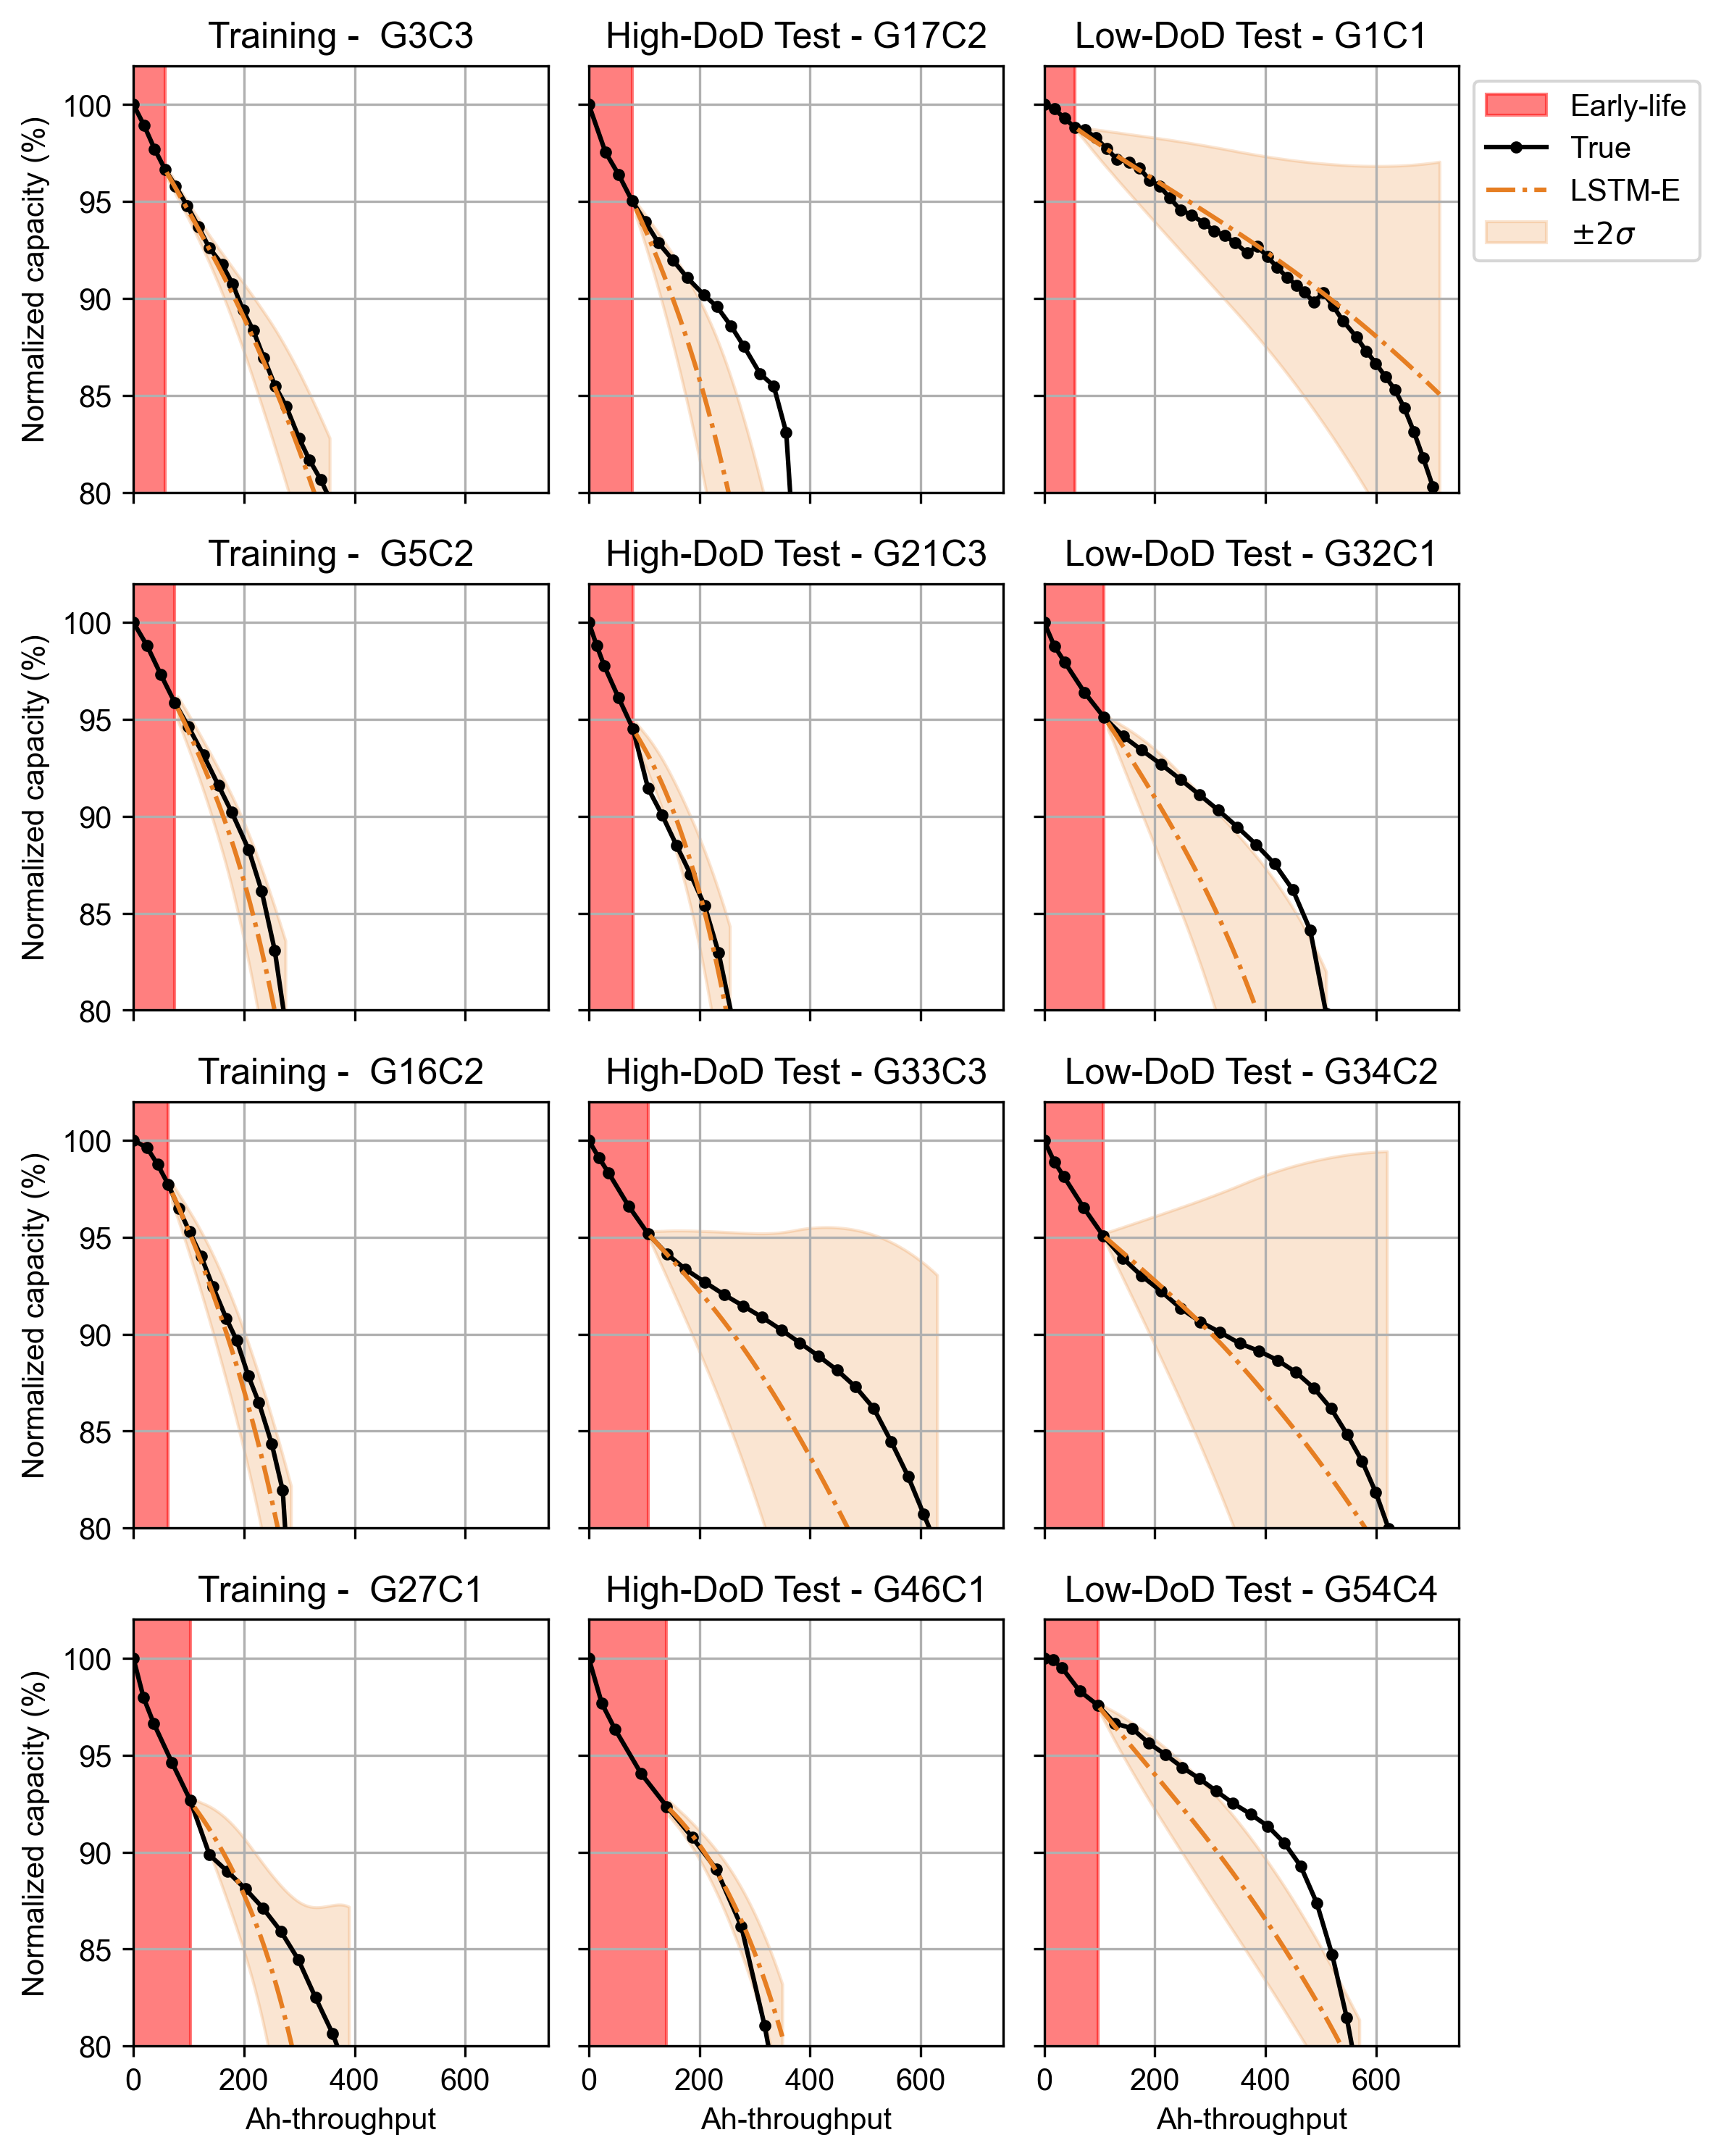

In [107]:
plot(3)